In [1]:
# NOTE:
# Regular PINN. 
# Use phys_loss_weight to set the weight of the physics loss 

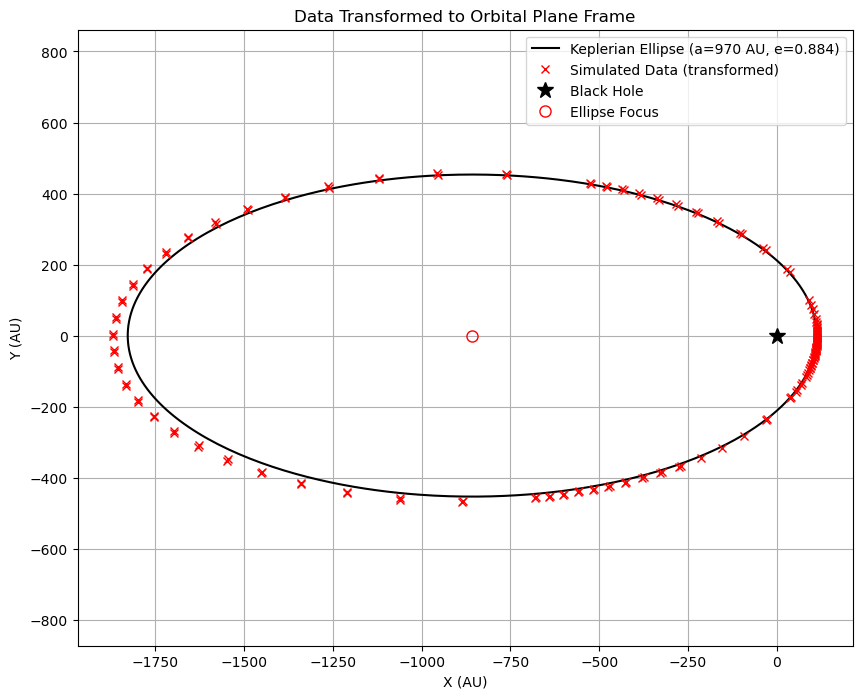

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load data (replace with your actual file paths)
data = pd.read_csv("data/simulated_data.csv")

# Extract RA/Dec in arcseconds
y = data.iloc[:,2].values  # Dec (arcsec)
x = data.iloc[:,1].values  # RA (arcsec)

# Constants
distance_gc = 7900  # parsecs
pc_to_au = 206265
mas_to_rad = np.pi / (180 * 3600 * 1000)

# S2 Orbital Elements (GRAVITY 2020)
a = 970  # AU
e = 0.884
i = np.radians(134.18)
Ω = np.radians(227.85)
ω = np.radians(66.12)

# Thiele-Innes elements
A = np.cos(ω)*np.cos(Ω) - np.sin(ω)*np.sin(Ω)*np.cos(i)
B = np.cos(ω)*np.sin(Ω) + np.sin(ω)*np.cos(Ω)*np.cos(i)
F = -np.sin(ω)*np.cos(Ω) - np.cos(ω)*np.sin(Ω)*np.cos(i)
G = -np.sin(ω)*np.sin(Ω) + np.cos(ω)*np.cos(Ω)*np.cos(i)

# Transformation matrix (observer -> orbital plane)
M_inv = np.array([[F, -G], [-A, B]]) / (B*F - A*G)

def mas_to_au(ra_mas, dec_mas):
    """Convert mas to AU (data is already BH-centered)"""
    return (ra_mas * mas_to_rad * distance_gc * pc_to_au, 
            dec_mas * mas_to_rad * distance_gc * pc_to_au)

def transform_to_orbital_plane(ra_au, dec_au):
    """Transform BH-centered observer coords to orbital plane"""
    X = M_inv[0,0]*ra_au + M_inv[0,1]*dec_au
    Y = M_inv[1,0]*ra_au + M_inv[1,1]*dec_au
    return X, Y


# Generate Keplerian ellipse
theta = np.linspace(0, 2*np.pi, 1000)
r = a * (1 - e**2) / (1 + e * np.cos(theta))
X_ellipse = r * np.cos(theta)
Y_ellipse = r * np.sin(theta)

# Transform data to orbital plane
x_au, y_au = mas_to_au(x * 1000, y * 1000)
x, y = transform_to_orbital_plane(-x_au, y_au)

# Plotting
plt.figure(figsize=(10, 8))
plt.plot(X_ellipse, Y_ellipse, 'k-', label='Keplerian Ellipse (a={} AU, e={})'.format(a, e))
plt.plot(x, y, 'rx', label='Simulated Data (transformed)')
plt.plot(0, 0, 'k*', markersize=12, label='Black Hole')  # BH is at focus, not center

# Mark focus (BH position in orbital plane)
focus = -e * a  # For ellipse centered at (0,0), focus at (-ea,0)
plt.plot(focus, 0, 'ro', markersize=8, fillstyle='none', label='Ellipse Focus')

plt.xlabel("X (AU)"); plt.ylabel("Y (AU)")
plt.title("Data Transformed to Orbital Plane Frame")
plt.axis('equal'); plt.grid(); plt.legend()
plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import random

#from model import PINN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


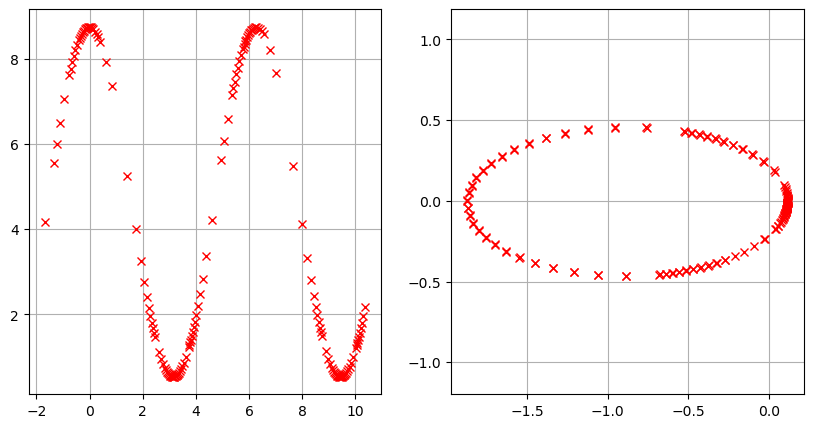

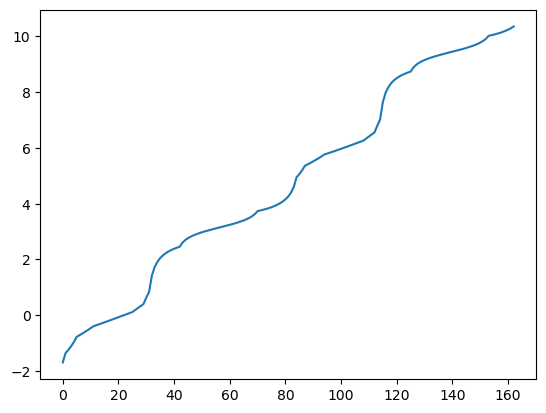

In [4]:
from SLoader import SLoader

scaling = 1e-3
x_ = x* scaling 
y_ = y* scaling

u = 1/np.sqrt(x_**2 + y_**2)
phi = np.arccos(x_*u)
phi = np.where(y<0, -phi, phi)

phi[57:] += 2*torch.pi
phi[139:] += 2*torch.pi

#phi[:19] = -phi[:19]
#phi[19:] += torch.pi
#phi[50:108] = torch.pi*3-phi[50:108]
#phi[108:] += torch.pi*3

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].plot(phi, u, 'rx')
ax[0].grid()

ax[1].plot(x_, y_, 'rx')
ax[1].grid()
ax[1].axis('equal');

plt.show()

plt.plot(phi)


phi = torch.tensor(phi).float().unsqueeze(1)
u = torch.tensor(u).float().unsqueeze(1)



In [ ]:

def grad(out, inp):
    return torch.autograd.grad(out, 
                               inp, 
                               grad_outputs=torch.ones_like(out), 
                               create_graph=True,
                               allow_unused=True)



class NNBlock(nn.Module):
    """
    Standard Feed Forward Neural Network 
    """
    def __init__(self, in_chan, out_chan, chans=[5,10,5], dropout_prob=0.1):
        super().__init__()

        #self.in_block = nn.Linear(in_chan, chans[0])

        layers = []

        layers.append(nn.Linear(in_chan, chans[0]))
        layers.append(nn.Tanh())
        #layers.append(nn.Dropout(p=dropout_prob))

        for i in range(len(chans) - 1):
            layers.append(nn.Linear(chans[i], chans[i+1]))
            layers.append(nn.Tanh())
            #layers.append(nn.Dropout(p=dropout_prob))

        layers.append(nn.Linear(chans[-1], out_chan))

        self.blocks = nn.Sequential(*layers)

    def forward(self, x):
        #y = torch.sin(self.in_block(x))
        #return self.blocks(y)
    
        return self.blocks(x)


class PINN(nn.Module):
    """
    Physics Informed Neural Network. 
        * physical_loss :
            Calculates the physical loss using 
            - returns torch.tensor
    """
    def __init__(self, in_chan=1, out_chan=1, chans=[5,10,5]):
        super().__init__()
        self.nn = NNBlock(in_chan, out_chan, chans=chans)

        self.e_ = torch.nn.Parameter(torch.abs(torch.randn(3)/10))
        self.mu_ = torch.nn.Parameter(torch.abs(torch.randn(3)/10))
        self.M_ = torch.nn.Parameter(torch.abs(torch.randn(3)/10))

    def forward(self, x):
        mu = self.get_mu()
        M  = self.get_M()
        e  = self.get_e()
        u = mu/M * (1 + e*torch.cos(self.nn(x)))
        return u
    
    def get_e(self):
        #return torch.abs(self.e_)
        #return torch.tanh(torch.abs(self.e_[0]*self.e_[1] + self.e_[2]))
        return torch.abs(self.e_[0]*self.e_[1] + self.e_[2])
    
    def get_M(self):
        return torch.abs(self.M_[0]*self.M_[1] + self.M_[2])
        #return torch.exp(self.M_)
    
    def get_mu(self):
        return torch.abs(self.mu_[0]*self.mu_[1] + self.mu_[2])
        #return torch.exp(self.mu_)
    
    def get_p(self):
        return self.get_M()/self.get_mu()
        #return self.M_/self.mu_
        #return torch.exp(self.p_)

    def physical_loss(self, phi, lambda1=1., lambda2=1.):
        chi = self.nn(phi)

        mu = self.get_mu()#.detach()#.item()
        #M  = self.get_M()
        e  = self.get_e()#.item()

        #u = mu/M * (1 + e*torch.cos(chi))

        #dchi = grad(chi, phi)[0] # dchi/dphi = dchi/du * du/dphi = du/dphi * du/dchi
        #ddchi = grad(dchi, phi)[0]

        dchi = torch.autograd.grad(chi, phi, 
                               grad_outputs=torch.ones_like(chi), 
                               create_graph=True,
                               allow_unused=True)[0]
        
        ddchi = torch.autograd.grad(dchi, 
                               phi, 
                               grad_outputs=torch.ones_like(dchi), 
                               create_graph=True)[0]
    

        ode1 = dchi**2 - (1 - 2*mu*(3 + e*torch.cos(chi)))
        ode2 = ddchi - mu*e*torch.sin(chi)

        # L2 Loss
        loss1 = torch.mean(ode1**2)
        loss2 = torch.mean(ode2**2)

        # L1 Loss
        #loss1 = torch.mean(ode1)
        #loss2 = torch.mean(ode2)

        # Inverse loss
        #loss1 = torch.mean(1/(ode1 + 1e-6)**2)
        #loss2 = torch.mean(1/(ode2 + 1e-6)**2)
        
        loss1 *= lambda1
        loss2 *= lambda2

        return loss1 + loss2

In [6]:
# Initialize model
#lr = 2e-5
#lr = 5e-4
lr = 1e-4

#model = PINN(1, 1, chans=[8,16,32,16,8]).to(device)
model = PINN(1, 1, chans=[16,]*5).to(device)

#optimizer = optim.SGD(lr=lr, params=model.parameters())
#optimizer = optim.Adagrad(lr=lr, params=model.parameters())
optimizer = optim.Adam(lr=lr, params=model.parameters(), weight_decay=1e-5)
#criterion = nn.MSELoss()
criterion = nn.L1Loss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
                patience=500, threshold=0.01, verbose=True, cooldown=250, eps=1e-6)


losses = [[], []]
params = [[], [], []]

#phi_lin = torch.linspace(-2.1*torch.pi, 4.2*torch.pi, steps=1000).view(-1,1).requires_grad_(True)
N = 2.  # How many pi do I want to extend the angles with, when evaluating the physics
phi_lin = torch.linspace(phi.min() - torch.pi*N, phi.max() + torch.pi*N, steps=256).view(-1,1).requires_grad_(True)

#phys_loss_weight = 1e-3 #1e-4
phys_loss_weight = 0#1e-5

batch_size = 16
batch_size_phys = 128

epoch = 0

In [31]:
epochs = 10_000

for i in tqdm(range(epochs)):
    epoch += 1
    ind = torch.tensor(random.sample(range(len(phi)), batch_size))
    ind_p = torch.tensor(random.sample(range(len(phi_lin)), batch_size_phys))

    phi_ = phi#[ind]
    #if epoch < epoch_start:
    #phi_ = (phi_ + (torch.randint(low=0,high=3,size=phi_.shape) - 1) * 2 * torch.pi)

    u_ = u#[ind]
    phi_lin_ = phi_lin#[ind_p]

    phi_ = phi_.to(device)
    u_ = u_.to(device)
    phi_lin_ = phi_lin_.to(device)
    
    out = model(phi_)

    MSEloss = criterion(out, u_)
    #MSEloss = 0.5*criterion(1/out, 1/u_) + 0.5*criterion(out, u_)
    #MSEloss = criterion(torch.log(out), torch.log(u_))
    #MSEloss = criterion(1/out, 1/u_)    # Minimize difference in r
    #MSEloss = criterion(torch.log(out + 1e-8), torch.log(u + 1e-8))    # Minimize relative difference
    #MSEloss = torch.mean(torch.abs(out - u) / (torch.abs(u)))    # Minimize MSE weightet by r

    #phi_lin = (torch.randn(1000, 1, requires_grad=True) * 10).to(device)
        
    PHYSloss = phys_loss_weight * model.physical_loss(phi_lin_)
    #PHYSloss = phys_loss_weight * model.physical_loss(phi_aug)
    #phys_loss_weight *= 1.005
    #phys_loss_weight = min(phys_loss_weight, max_phys_loss_weight)

    losses[0].append(MSEloss.item())
    losses[1].append(PHYSloss.item())

    loss = MSEloss + PHYSloss

    optimizer.zero_grad()
    loss.backward()
    #if epoch % 2 == 0:
    #    MSEloss.backward()
    #else:
    #    PHYSloss.backward()
    #MSEloss.backward()
    #PHYSloss.backward()
    optimizer.step()
    #scheduler.step(loss)
    #scheduler.step(torch.log10(loss))

    params[0].append(model.get_e().item())
    params[1].append(model.get_mu().item())
    params[2].append(model.get_M().item())


100%|██████████| 10000/10000 [00:49<00:00, 202.85it/s]


0
tensor(0.2425, grad_fn=<MeanBackward0>)
tensor(0.3710, grad_fn=<MeanBackward0>)


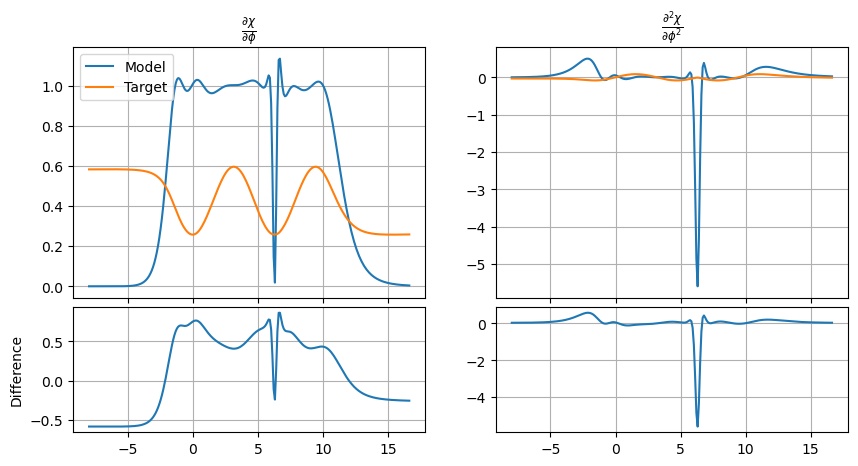

In [32]:
def grad(out, inp):
    return torch.autograd.grad(out, 
                               inp, 
                               grad_outputs=torch.ones_like(out), 
                               create_graph=True)

_phi = phi_lin # torch.linspace(-2*torch.pi, 4*torch.pi, steps=1000).view(-1,1).requires_grad_(True)
chi = model.nn(_phi.to(device)).cpu()

mu = model.get_mu().item()
#p  = self.get_p()
#M  = self.get_M()
e  = model.get_e().item()

dchi = grad(chi, _phi)[0]
ddchi = grad(dchi, _phi)[0]

ode1 = dchi**2 - (1 - 2*mu*(3 + e*torch.cos(chi)))
ode2 = ddchi - mu*e*torch.sin(chi)

print(phys_loss_weight)
print(torch.mean(ode1**2))
print(torch.mean(ode2**2))

_phi = _phi.detach().numpy()
dchi = dchi.detach().numpy()
ddchi = ddchi.detach().numpy()
chi = chi.detach()
ode1 = ode1.detach().numpy()
ode2 = ode2.detach().numpy()

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,5), gridspec_kw={'height_ratios':[2,1]}, sharex=True)
ax[0,0].grid()
ax[0,0].set_title(r"$\frac{\partial \chi}{\partial \phi}$")
ax[0,0].plot(_phi, dchi**2, label="Model")
ax[0,0].plot(_phi, (1 - 2*mu*(3 + e*torch.cos(chi))), label="Target")
ax[0,0].legend()

ax[0,1].grid()
ax[0,1].set_title(r"$\frac{\partial^2 \chi}{\partial \phi^2}$")
ax[0,1].plot(_phi, ddchi)
ax[0,1].plot(_phi, mu*e*torch.sin(chi))

ax[1,0].grid()
ax[1,0].set_ylabel("Difference")
ax[1,0].plot(_phi, ode1)

ax[1,1].grid()
ax[1,1].plot(_phi, ode2)

plt.subplots_adjust(hspace=.05)

e = 0.8848254680633545
p = 0.21551570296287537
M = 0.020601719617843628
mu = 0.09559266269207001
M-model-data = 0.9980600476264954


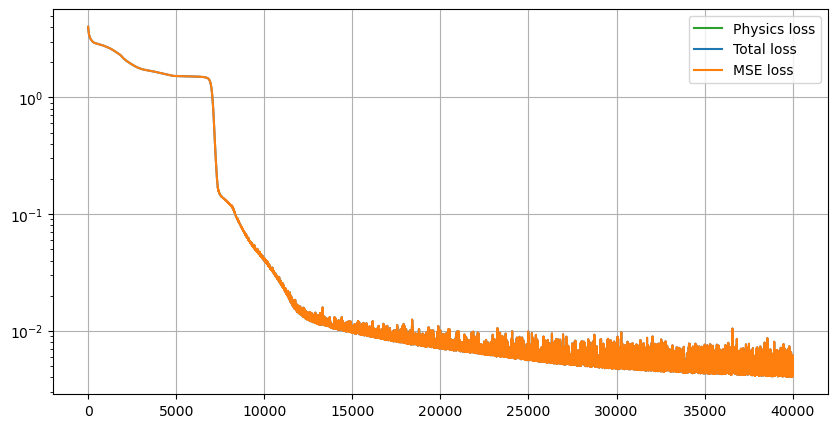

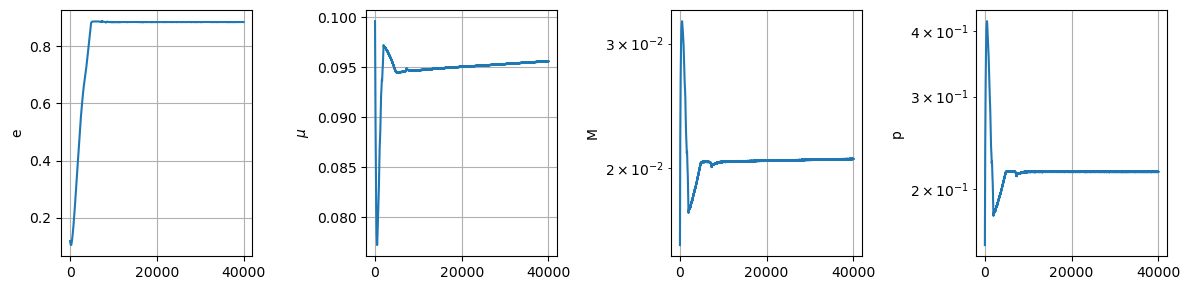

In [33]:
print("e =", model.get_e().item())
#print("p =", model.get_M().item()/model.get_mu().item())
print("p =", model.get_p().item())
print("M =", model.get_M().item())
print("mu =", model.get_mu().item())


M_md = torch.mean(1 - torch.abs(model(phi.to(device)).cpu() - u)/u).item()
print("M-model-data =", M_md)


fig, ax = plt.subplots(figsize=(10,5))

ax.plot(losses[1], label="Physics loss", c="tab:green")
ax.plot(np.array(losses[0]) + np.array(losses[1]), label="Total loss", c="tab:blue")
ax.plot(losses[0], label="MSE loss", c="tab:orange")

ax.grid()
ax.legend()
ax.set_yscale("log")
plt.show()


fig, ax = plt.subplots(ncols=4, figsize=(12,3))

ax[0].plot(params[0])
ax[0].set_ylabel("e")
ax[0].grid()

ax[1].plot(params[1])
ax[1].set_ylabel(r"$\mu$")
#ax[1].set_ylabel("p")
ax[1].grid()

ax[2].plot(params[2])
ax[2].set_ylabel("M")
ax[2].grid()
ax[2].set_yscale("log")

ax[3].plot(np.array(params[2])/np.array(params[1]))
ax[3].set_ylabel("p")
ax[3].grid()
ax[3].set_yscale("log")


plt.tight_layout()
plt.show()

# e  ~ 0.884 (0.884)
# p  ~ 228 (223)
# mu ~ 1.8e-4
# M  ~ 0.04239 AU

# M-model-data ~ 0.9755

# print(model.get_p().item() / (1 - model.get_e().item()**2) * 1e-2)

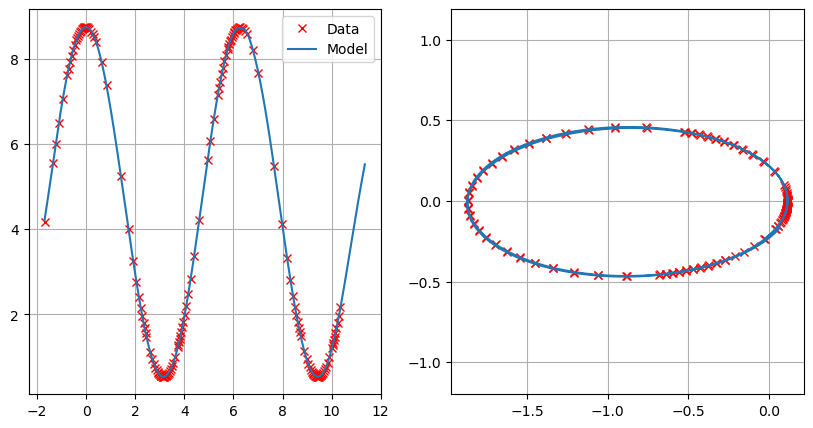

In [34]:
fig, ax = plt.subplots(figsize=(10,5), ncols=2)
_phi = phi
_u = u
ax[0].plot(_phi, _u, 'rx', label="Data")


theta = torch.linspace(_phi.min(), _phi.max()+1, steps=1000, dtype=torch.float32).to(device)
u_ = model(theta.unsqueeze(1)).cpu().detach().numpy()[:,0]
theta = theta.cpu()
ax[0].plot(theta, u_, label="Model")
#ax[0].vlines(torch.pi/2, _u.min(), _u.max(), 'k', ls='--')
#ax[0].vlines(3*torch.pi/2, _u.min(), _u.max(), 'k', ls='--')
#ax[0].vlines(2*torch.pi, _u.min(), _u.max(), 'r', ls='--')
#ax[0].vlines(torch.pi, _u.min(), _u.max(), 'r', ls='--')


#ax[1].plot(x1, y1, 'rx')
#ax[1].plot(x2, y2, 'rx')
ax[1].plot(torch.cos(_phi[:,0])/_u[:,0], torch.sin(_phi[:,0])/_u[:,0], "rx")

r = 1/u_

theta = theta.numpy()
ax[1].plot(r*np.cos(theta), r*np.sin(theta));


# e  ~ 0.884 (0.884)
# p  ~ 228 (223)
# mu ~ 1.8e-4
# M  ~ 0.04239 AU
#u_test = 1/228 * (1 + 0.884*torch.cos(model.nn(torch.tensor(theta).unsqueeze(1)))).detach().numpy()[:,0]
#ax[0].plot(theta, u_test, label="Target?")
#ax[1].plot(np.cos(theta)/u_test, np.sin(theta)/u_test)


[axi.grid() for axi in ax]
ax[1].axis('equal')
#ax[0].axis('equal')
ax[0].legend();
#ax.set_xscale("log")
#ax[0].set_xlim(2.75,3.5)
#ax[0].set_ylim(0.025,0.1)

0.0034974495596209465
f = 1.0021345443039962


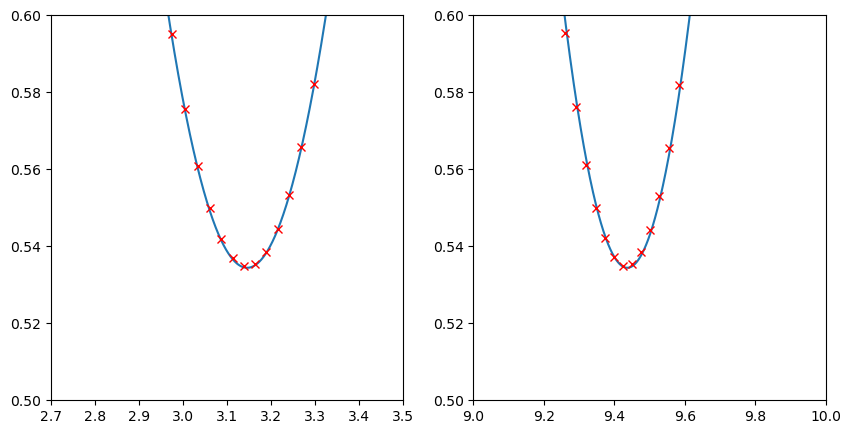

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
dl = 0.5

phi_ = torch.linspace(2,4,steps=2048).unsqueeze(1).to(device)
y = model(phi_).detach()
phi0 = phi_[torch.argmin(y)]
y0 = y.min()
ax[0].plot(phi_, y)
ax[0].plot(phi, u, 'rx')
#ax[0].set_ylim(y.min()*0.9, y.max()*1.1); ax[0].set_xlim(0.9*phi_.min(), phi_.max()*1.1)
ax[0].set_ylim(0.5,.6); ax[0].set_xlim(2.7,3.5)

phi_ = torch.linspace(8,10,steps=2048).unsqueeze(1).to(device)
y = model(phi_).detach()
phi1 = phi_[torch.argmin(y)]
ax[1].plot(phi_, y)
ax[1].plot(phi, u, 'rx')
#ax[0].set_ylim(y.min()*0.9, y.max()*1.1); ax[0].set_xlim(0.9*phi_.min(), phi_.max()*1.1)
ax[1].set_ylim(0.5,.6); ax[1].set_xlim(9,10)

print((phi1-phi0).item()/2 - torch.pi)
print(f"f = {(abs((phi1 - phi0).item()/2 - torch.pi))/0.00349}")

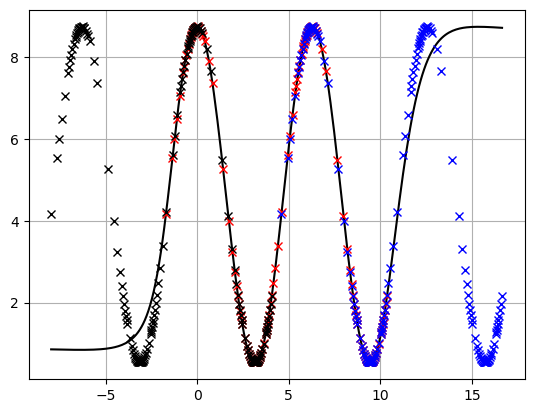

In [36]:
fig, ax = plt.subplots()
ax.grid()

u_ = model(phi_lin.to(device)).cpu().detach().numpy()[:,0]
theta = phi_lin.cpu().detach().numpy()

ax.plot(theta[:,0], u_, 'k')


ax.plot(phi.cpu(), u.cpu(), "rx")
phi_aug_ = phi + 2 * torch.pi
ax.plot(phi_aug_.cpu(), u.cpu(), 'bx')
phi_aug = phi - 2 * torch.pi
ax.plot(phi_aug.cpu(), u.cpu(), 'kx')

#plt.xlim(-2, -1)
#r = 1/u_
#theta = phi_lin.detach().numpy()
#ax.plot(r*np.cos(theta[:,0]), r*np.sin(theta[:,0]));


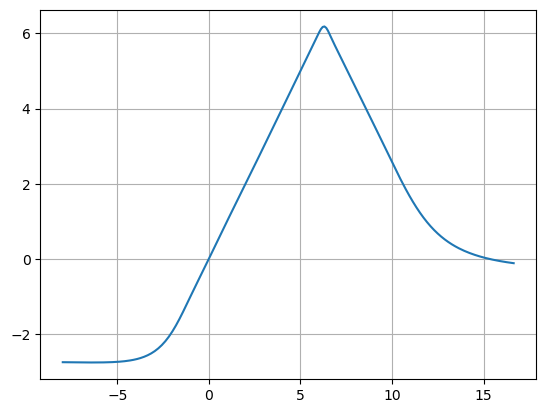

In [37]:
x = phi_lin
y = model.nn(x.to(device))

x = x.cpu().detach().numpy()
y = y.cpu().detach().numpy()

plt.plot(x,y)
plt.grid()

In [38]:
state = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
#torch.save(state, f'precession_4.pth')